In [24]:
import torch.nn as nn
import torchvision.models as models

class ResnetV1(nn.Module):
    def __init__(self, num_classes):
        super(ResnetV1, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.resnet = models.resnet50(pretrained=True)
        
        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Unfreeze the last 4 parameters (typically layers close to the output)
        for param in list(self.resnet.parameters())[-4:]:
            param.requires_grad = True
        
        # Modify the last fully connected layer to match the number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.resnet(x)
        return x


C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\1747412785.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_path, map_locat


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       322
           1       0.41      0.62      0.50       288
           2       0.38      0.19      0.26       248
           3       0.51      0.35      0.41       318
           4       0.72      0.77      0.74       505
           5       0.71      0.71      0.71       513
           6       0.34      0.29      0.32       310
           7       0.36      0.45      0.40       404

    accuracy                           0.51      2908
   macro avg       0.48      0.47      0.46      2908
weighted avg       0.51      0.51      0.50      2908



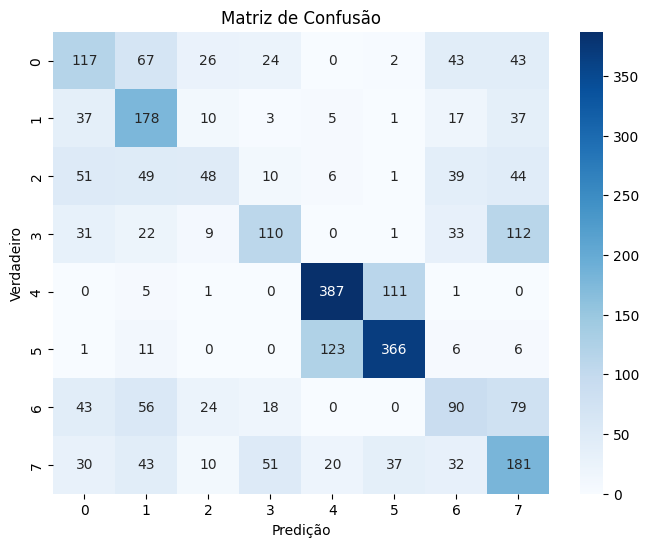


Métricas de Desempenho do Modelo:
Acuracia: 0.5079
Precisao: 0.5058
Recall: 0.5079
F1_score: 0.4996


In [25]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

class ModelTester:
    def __init__(self, model_class, model_path, device, data_loader_validacao):
        """
        Inicializa a classe ModelTester.

        Parâmetros:
        - model_class: A classe do modelo a ser instanciada.
        - model_path: Caminho para o modelo salvo (.pt).
        - device: Dispositivo onde o modelo será carregado (CPU ou GPU).
        - data_loader_validacao: DataLoader para o conjunto de validação.
        """
        self.model_class = model_class
        self.model_path = model_path
        self.device = device
        self.data_loader_validacao = data_loader_validacao

        # Carrega o modelo
        self.model = self.load_model()

    def load_model(self):
        """
        Carrega o modelo salvo a partir do caminho fornecido.
        """
        model = self.model_class(num_classes=8)  # Altere para o número correto de classes
        model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        model.to(self.device)
        model.eval()  # Coloca o modelo em modo de avaliação
        return model

    def test_model(self):
        """
        Avalia o modelo usando o conjunto de validação e retorna as principais métricas de avaliação.
        """
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in self.data_loader_validacao:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calcula as métricas
        acuracia = accuracy_score(all_labels, all_preds)
        precisao = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Exibe o relatório de classificação
        print("\nRelatório de Classificação:")
        print(classification_report(all_labels, all_preds, zero_division=0))

        # Exibe a matriz de confusão
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
        plt.xlabel('Predição')
        plt.ylabel('Verdadeiro')
        plt.title('Matriz de Confusão')
        plt.show()

        return {
            "acuracia": acuracia,
            "precisao": precisao,
            "recall": recall,
            "f1_score": f1
        }

# Configurações de dispositivo e carregamento de dados de validação
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformacoes_validacao = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

dataset_path = r'../data/affectnet/processed/imagens_processed'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Caminho do modelo salvo
model_path = 'models/modelo1affectnet.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\1747412785.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.38      0.33      0.35       280
           1       0.38      0.49      0.43       257
           2       0.41      0.13      0.20       220
           3       0.32      0.19      0.23       281
           4       0.78      0.77      0.77       453
           5       0.69      0.84      0.76       458
           6       0.29      0.29      0.29       273
           7       0.41      0.56      0.47       360

    accuracy                           0.51      2582
   macro avg       0.46      0.45      0.44      2582
weighted avg       0.49      0.51      0.49      2582



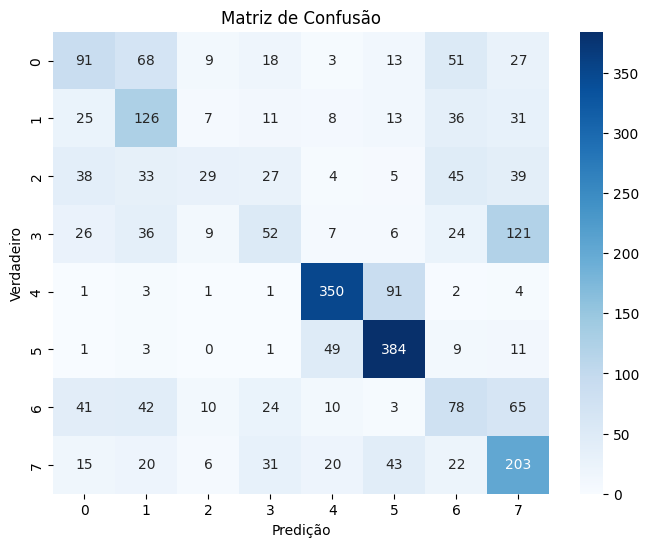


Métricas de Desempenho do Modelo:
Acuracia: 0.5085
Precisao: 0.4941
Recall: 0.5085
F1_score: 0.4893


In [26]:
dataset_path = r'../data/affectnet/processed/essenciais/'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1affectnetessenciais.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\1747412785.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.30      0.35      0.32       286
           1       0.26      0.45      0.33       258
           2       0.17      0.01      0.02       221
           3       0.36      0.28      0.31       284
           4       0.74      0.71      0.73       454
           5       0.62      0.81      0.70       461
           6       0.26      0.18      0.22       276
           7       0.35      0.36      0.36       363

    accuracy                           0.45      2603
   macro avg       0.38      0.39      0.37      2603
weighted avg       0.43      0.45      0.43      2603



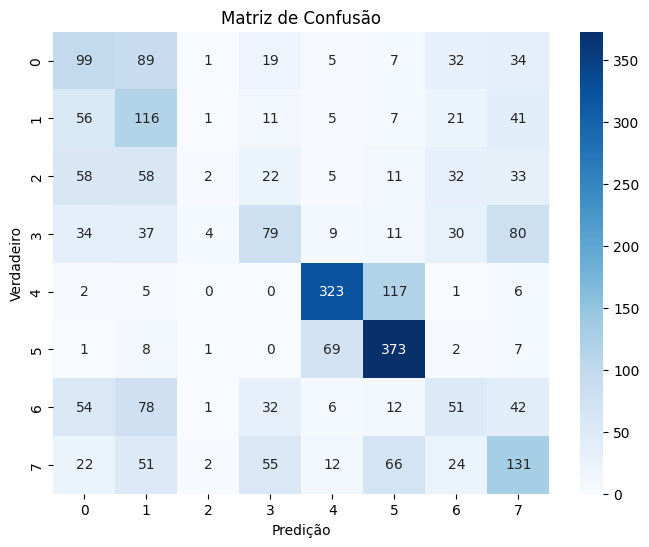


Métricas de Desempenho do Modelo:
Acuracia: 0.4510
Precisao: 0.4291
Recall: 0.4510
F1_score: 0.4278


In [27]:
dataset_path = r'../data/affectnet/processed/landmarks/'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1affectnetlandmarks.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\1747412785.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.40      0.48      0.44       286
           1       0.47      0.58      0.52       258
           2       0.33      0.25      0.28       222
           3       0.37      0.19      0.25       284
           4       0.88      0.83      0.86       454
           5       0.79      0.88      0.83       462
           6       0.37      0.24      0.29       277
           7       0.42      0.59      0.49       363

    accuracy                           0.56      2606
   macro avg       0.50      0.51      0.50      2606
weighted avg       0.55      0.56      0.55      2606



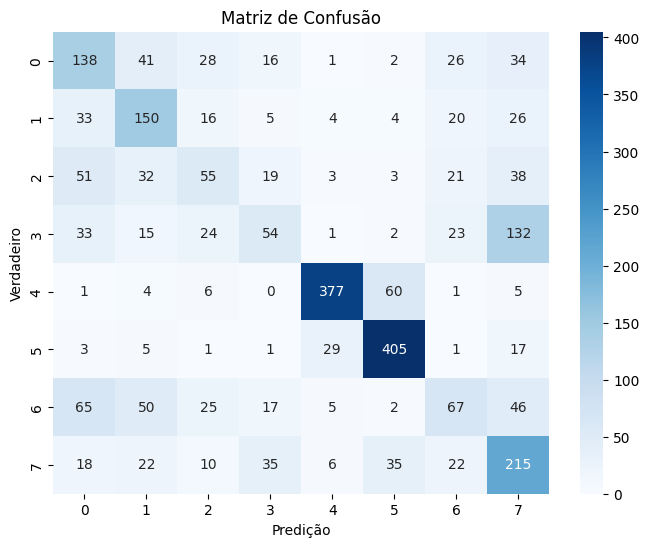


Métricas de Desempenho do Modelo:
Acuracia: 0.5606
Precisao: 0.5511
Recall: 0.5606
F1_score: 0.5473


In [28]:
dataset_path = r'../data/affectnet/processed/landmarksConected/'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1affectnetconected.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\2222958108.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.09      0.16       278
           1       0.32      0.20      0.24       281
           2       0.48      0.78      0.59       678
           3       0.43      0.38      0.40       459
           4       0.31      0.27      0.29       351
           5       0.54      0.55      0.54       262

    accuracy                           0.44      2309
   macro avg       0.43      0.38      0.37      2309
weighted avg       0.43      0.44      0.41      2309



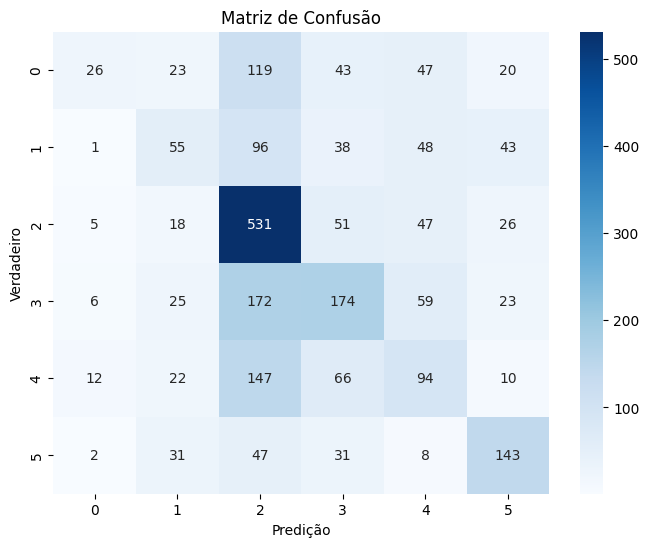


Métricas de Desempenho do Modelo:
Acuracia: 0.4430
Precisao: 0.4331
Recall: 0.4430
F1_score: 0.4081


In [34]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

class ModelTester:
    def __init__(self, model_class, model_path, device, data_loader_validacao):
        """
        Inicializa a classe ModelTester.

        Parâmetros:
        - model_class: A classe do modelo a ser instanciada.
        - model_path: Caminho para o modelo salvo (.pt).
        - device: Dispositivo onde o modelo será carregado (CPU ou GPU).
        - data_loader_validacao: DataLoader para o conjunto de validação.
        """
        self.model_class = model_class
        self.model_path = model_path
        self.device = device
        self.data_loader_validacao = data_loader_validacao

        # Carrega o modelo
        self.model = self.load_model()

    def load_model(self):
        """
        Carrega o modelo salvo a partir do caminho fornecido.
        """
        model = self.model_class(num_classes=6)  # Altere para o número correto de classes
        model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        model.to(self.device)
        model.eval()  # Coloca o modelo em modo de avaliação
        return model

    def test_model(self):
        """
        Avalia o modelo usando o conjunto de validação e retorna as principais métricas de avaliação.
        """
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in self.data_loader_validacao:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calcula as métricas
        acuracia = accuracy_score(all_labels, all_preds)
        precisao = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Exibe o relatório de classificação
        print("\nRelatório de Classificação:")
        print(classification_report(all_labels, all_preds, zero_division=0))

        # Exibe a matriz de confusão
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
        plt.xlabel('Predição')
        plt.ylabel('Verdadeiro')
        plt.title('Matriz de Confusão')
        plt.show()

        return {
            "acuracia": acuracia,
            "precisao": precisao,
            "recall": recall,
            "f1_score": f1
        }

# Configurações de dispositivo e carregamento de dados de validação
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformacoes_validacao = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])



dataset_path = r'../data/Fer-2013/processed/imagens_processed'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1fer.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\2222958108.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.39      0.18      0.25       277
           1       0.20      0.00      0.01       281
           2       0.66      0.79      0.72       678
           3       0.34      0.67      0.45       459
           4       0.30      0.16      0.21       351
           5       0.55      0.58      0.56       262

    accuracy                           0.48      2308
   macro avg       0.41      0.40      0.37      2308
weighted avg       0.44      0.48      0.43      2308



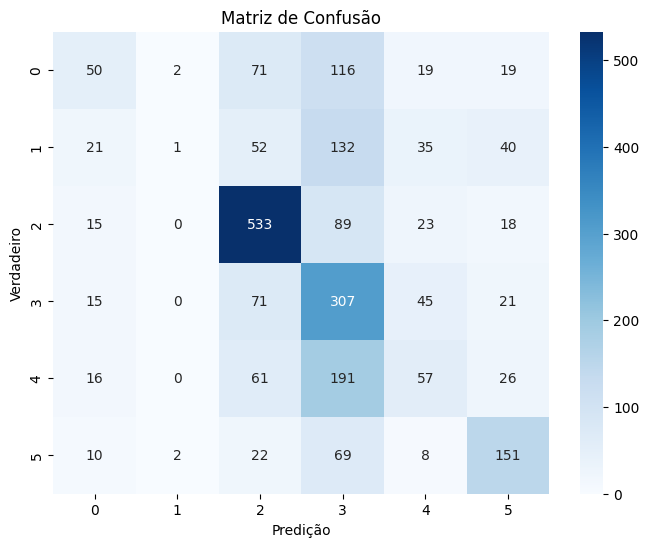


Métricas de Desempenho do Modelo:
Acuracia: 0.4762
Precisao: 0.4411
Recall: 0.4762
F1_score: 0.4267


In [30]:
dataset_path = r'../data/Fer-2013/processed/essenciais/'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1feressenciais.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\2222958108.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.29      0.07      0.11       278
           1       0.00      0.00      0.00       281
           2       0.58      0.73      0.65       678
           3       0.32      0.61      0.42       459
           4       0.30      0.14      0.19       351
           5       0.43      0.55      0.49       262

    accuracy                           0.43      2309
   macro avg       0.32      0.35      0.31      2309
weighted avg       0.36      0.43      0.37      2309



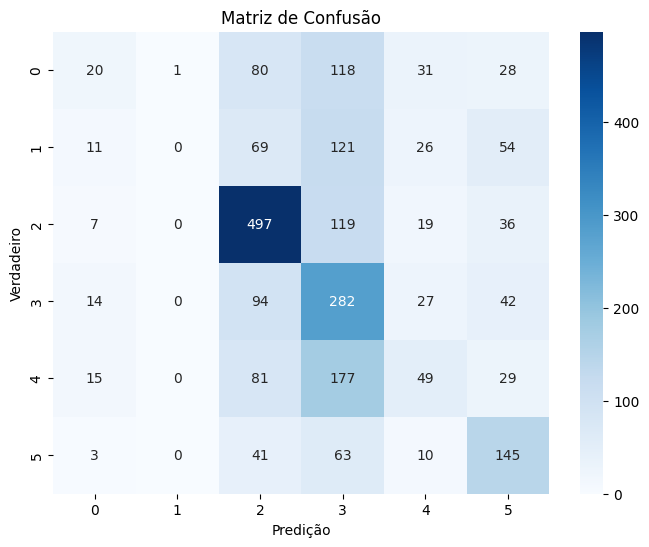


Métricas de Desempenho do Modelo:
Acuracia: 0.4301
Precisao: 0.3626
Recall: 0.4301
F1_score: 0.3713


In [31]:
dataset_path = r'../data/Fer-2013/processed/landmarks/'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1ferlandmarks.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_14268\2222958108.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.51      0.17      0.25       278
           1       0.14      0.01      0.02       281
           2       0.56      0.86      0.68       678
           3       0.39      0.61      0.48       459
           4       0.32      0.17      0.22       351
           5       0.63      0.60      0.61       262

    accuracy                           0.49      2309
   macro avg       0.43      0.40      0.38      2309
weighted avg       0.44      0.49      0.43      2309



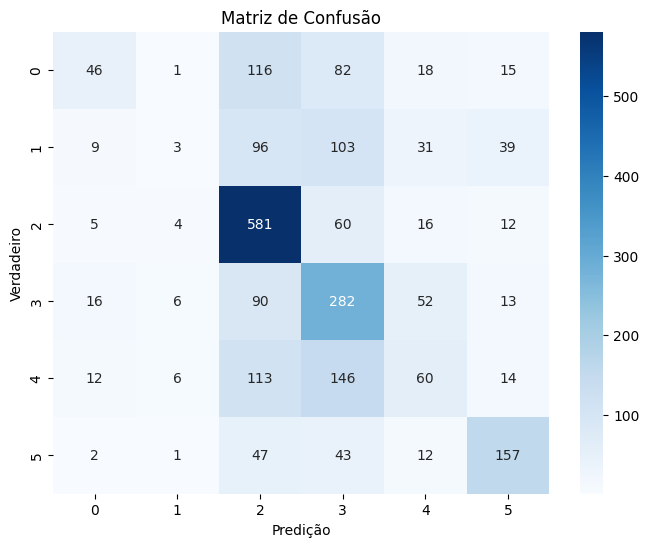


Métricas de Desempenho do Modelo:
Acuracia: 0.4890
Precisao: 0.4403
Recall: 0.4890
F1_score: 0.4296


In [32]:
dataset_path = r'../data/Fer-2013/processed/landmarksFullConected/'
# Cria o DataLoader de validação
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_path = 'models/modelo1ferconected.pt'  # Substitua pelo caminho do seu modelo

# Inicializa o testador e executa o teste
tester = ModelTester(ResnetV1, model_path, device, data_loader_validacao)
resultados = tester.test_model()

# Exibe as métricas de desempenho do modelo
print("\nMétricas de Desempenho do Modelo:")
for metric, value in resultados.items():
    print(f"{metric.capitalize()}: {value:.4f}")